# Introduction

Anyone who has worked with data has encountered an observation that is radically different from the rest of their data. These points, called outliers makes one question their data; how it was collected, how it was processed, whether they are looking at it properly. Outliers can be a nuisance, unimportant, or even maliciously designed, so idetifying and resolving them is an important, yet difficult problem.

More formally, an outlier is "an observation which deviates so much from other observations as to arouse suspicions that it was generated by a different mechanism" (Hawkins, 1980). Outliers are broadly defined, and often come from measurement error, data processing issues, or natural observations, to name a few. Moreover, the presence of outliers can impact one's experiment in a number of ways. For example, in order of increasing severity, outliers can account for:

- issues in the execution of your experiment (e.g miscalibrated sensors)
- unexepected variance in results (e.g. a few observations that vary substantially, and can be removed)
- intentional intereference with data (e.g. credit card fraud)

In any case, outliers give cause for suspicion, and one would like to identify them whenever possible. **Outlier Detection** (also called Anomaly Detection) refers to the process of identifying outliers. Once identified, the analyst can decide how to resolve them. Outlier Detection is extremely domain-specific, and general-purpose solutions are difficult to achieve (Jinka, 2016). 

This paper provides an introductory framework for classifying and resolving outliers. This framework will show how general-purpose algorithms can be utilized to conduct domain-speficic outlier detection. The methods under consideration are Density-Based Spatial Clustering of Applications with Noise (**DBSCAN**) and Isolation Forests (**IsoForest**). To explore these methods, this paper will conduct outlier detection on two datasets:

1. Spatial GPS data of an aircraft, where outliers are incorrect position measurements that should be removed.
2. Prices of avocados in various regions over a period of ~3 years, where outliers are considered to be naturally occuring, and are worth further investigation.
 
This paper includes python code and output, so that it is useful to practioners.

In [1]:
# python libraries

# data handling/processing libraries
#   pandas - data tables
#   numpy - vector algebra
import pandas as pd
import numpy as np

# plotting libraries
#   matplotlib - basic plotting
#   seaborn - statistical plotting and improved styling 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper")

# scientific computing utilities
from scipy.spatial.distance import pdist, squareform

# machine learning utilities
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

# custom utilities
from utils import print_confusion_matrix, plot_dbscan_results

In [2]:
# ignore warnings from scikit-learn
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Spatial Outlier Detection

Consider GPS latitude/longitude data for an aircraft. First, I will load the data and then display the 2-dimensional trajectory without outliers.

> **Note**: The data is scaled, for purposes of anonymity

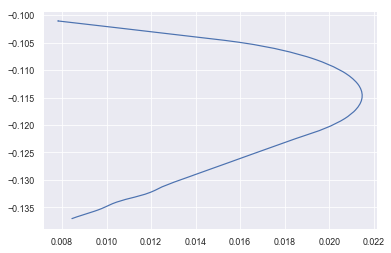

In [24]:
# load gps data
gps = pd.read_csv("./data/gps.csv")

# identify true trajectory
gps_outlier = ~gps['is_outlier']
gps_true = gps.loc[gps_outlier]

# plot true trajectory (no outliers)
plt.plot(gps_true['x'], gps_true['y']);

The trajectory looks reasonable, meaning that we could expect an aircraft to make this maneuver. However, when we include outliers, the picture is incomprehensible:

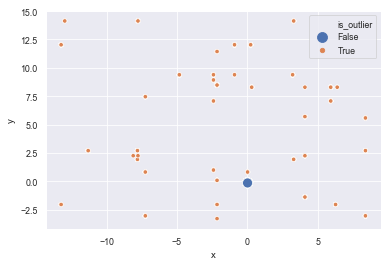

In [4]:
# plot entire trajectory, label outliers
sns.scatterplot(data=gps, x='x', y='y', hue='is_outlier', 
                size='is_outlier', sizes=(20, 100));

It is difficult to see, but the original trajectory is all clustered at the blue dot, and is undetectable when outliers are included (Notice the scale between this plot and the previous one is vastly different). I propose that:

- the outliers are due to measurement/sensor errors
- the outliers should be removed

In the following sections, I explore different approaches for outlier detection.

## Naive Approaches

At first glance, there are several intuitive ways to identify the outliers. For example, I could:

- calculate distances from the centroid, and classify observations that are far (more than 3 standard deviations) from the centroid as outliers
- calculate velocity and acceleration from the position data, and use my knowledge of the aircraft's physical limitations to classify points that are outside of these limitations as outliers

These approaches seem promising at first glance, but neither are necessarily generalizable. The centroid-based approach is not necessarily robust, meaning it may be sensitive to outliers if there are enough of them. This means it may classify outliers incorrectly, leading to the removal of actual data points. 

On the other hand, the velocity/acceleration-based approach requires more domain-specific knowledge, and even non-outliers can produce noisy velocity/acceleration calculations. This means that unless care is taken (i.e. domain-specific knowledge is further emphasized), incorrect outlier classification is likely.

Overall, even if these approaches work for this case, it's unlikely that they'll work with GPS data for another object (e.g. a car, or a faster aircraft). Therefore, I would like to consider other approaches.

The following sections will introduce the DBSCAN and IsoForest algorithms in the context of this problem.

## DBSCAN

The DBSCAN method has been widely used for clustering since its introduction in 1996 (Ester). Given a set of points, DBSCAN groups points into clusters based on a distance function and a tolerance $\epsilon > 0$ that determines whether two points are close to one-another. The picture below is from the [scikit-learn documentation on DBSCAN](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py), and shows three clusters. The black points were not included in any of the clusters, and are considered to be outliers or noise.

![dbscan example](assets/dbscan-sklearn.png)

Some advantages of DBSCAN are

- clusters are arbitrarily shaped
- it is robust to outliers
- relatively simple algorithm (two inputs, easily interpretable)

Some disadvantages are

- it may take a while to train for large datasets
- distance function is crucial to success of DBSCAN; often the euclidean distance function is used, but this may not be the best option
- choosing $\epsilon$ may be difficult without domain-specific expertise

For the GPS problem, I will use DBSCAN with the euclidean distance function and $\epsilon = 0.01$. If any number of points, they will be put in the same cluster. For this data, I expect there to be one cluster that contain many points, and a handful of points that DBSCAN identifies as outliers, or puts into much smaller clusters.

Below, I fit a DBSCAN model.

In [5]:
# initialize DBSCAN model
gps_dbs = DBSCAN(eps=0.01)

# fit GPS data
gps_dbs.fit(gps[["x", "y"]])

DBSCAN(algorithm='auto', eps=0.01, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [6]:
# apply labels to data
# determine which groups are outliers
gps_unique_labels, gps_label_counts = np.unique(gps_dbs.labels_, 
                                                return_counts=True)
gps_unique_counts = pd.Series(gps_label_counts, 
                              index=gps_unique_labels).sort_values(ascending=False)

print('Top DBSCAN labels \n')
print(gps_unique_counts.head())
print(f'\nThere are {len(gps_unique_counts)} labels in total')

Top DBSCAN labels 

0     33880
14       67
6        63
16       53
30       50
dtype: int64

There are 33 labels in total


These results show 

- there are 33880 observations with label 0
- There are 31 other clusters (labels with -1 are considered "outliers"), but they all contain far fewer points than those with label 0. 

Therefore, consider any observation without label 0 to be an outlier. The plot below show the trajectory, with these outliers removed.

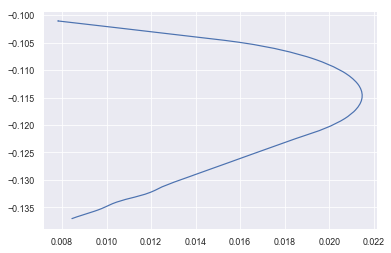

In [7]:
# remove outliers from trajectory
dbscan_is_outlier = gps_dbs.labels_ != 0
dbscan_results = gps.loc[~dbscan_is_outlier]

# plot trajectory without outliers
plt.plot(dbscan_results['x'], dbscan_results['y']);

Lastly, the confusion matrix shows perfect matching. There were no false-positives or true-negatives, meaning each outlier was properly classified.

In [8]:
print_confusion_matrix(gps['is_outlier'], dbscan_is_outlier)

                Inlier (True)  Outlier (True)
Inlier (Pred)           33880               0
Outlier (Pred)              0             824


Next, I consider IsoForest, a Random Forest approach that comes with its own advantages (and disadvantages).

## IsoForest

Isolation Forest, or IsoForest, uses random forests to detect features that identify outliers. It was introduced in Liu's 2008 paper "Isolation Forest". From the [scikit-learn user guide](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest):

> One efficient way of performing outlier detection in high-dimensional datasets is to use random forests. The [Isolation Forest] ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In picking/splitting features at random across decision trees, one would expect an outliers to occur much sooner in the decision tree than other features. Thus, if many random trees result in short path lengths for a sample, it is likely an outlier. The plot below shows an example from the same user guide:

![isolation forest example](assets/isoforest-sklearn.png)

Some advantages of IsoForest are

- it has linear time complexity
- it does not require a distance function
- it is easily scalable to large/high-dimensional data

Some disadvantages are

- lower accuracy
- single-purpose, i.e. only classifies samples as inliers or outliers

> **Note**: single-purpose algorithms are not necessarily bad. It can be argued that it's an advantage or a disadvantage, depending on how one plans to use it.

For the GPS problem, I use IsoForest to identify potential outliers. It accepts several parameters, but that is beyond the scope of this discussion. Therefore, I fit IsoForest using the scikit-learn default parameters.

In [9]:
# initialize IsoForest model
gps_iso = IsolationForest()

# fit GPS data
gps_iso.fit(gps[["x", "y"]])

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=None, verbose=0)

This algorithm returns -1 for outliers, and 1 for inliers. Below, I remove the outliers, and plot the results.

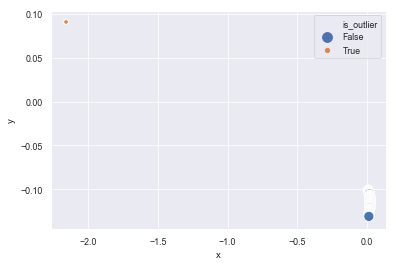

In [10]:
# predict labels
iso_labels = gps_iso.predict(gps[["x", "y"]])

# apply labels to data
iso_is_outlier = iso_labels == -1
iso_results = gps.loc[~iso_is_outlier]

# plot data with outliers removed
sns.scatterplot(data=iso_results, x='x', y='y', hue='is_outlier', 
                size='is_outlier', sizes=(20, 100));

The picture is much better than it previously was, but there are still a few outliers the IsoForest failed to capture. The confusion matrix, shown below, gives a better idea of the performance.

In [11]:
print_confusion_matrix(gps['is_outlier'], iso_is_outlier)

                Inlier (True)  Outlier (True)
Inlier (Pred)           31221            2659
Outlier (Pred)             12             812


These results are not as accurate as those from DBSCAN, but IsoForest was much faster, and still identified many outliers correctly.

Overall, DBSCAN was slower and more accurate, while IsoForest was faster but less accurate. One should use the method that fits best for their use-case. For this case, DBSCAN is preferred for its accuracy.

Next, I look at an entirely different approach: using DBSCAN to detect outliers, and then using IsoForest to identify anomalous features of those outliers.

# Time Series Outlier Detection (An Experiment)

Outlier Detection can be an open-ended problem. Consider the following data, which contains the average price of an avocado for 54 regions in the United States every week from January 2015 to March 2018. The data is plotted below, with the price of avocados in the Philadelphia area highlighted.


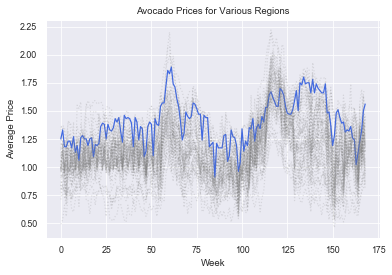

In [25]:
# load avocado data
avo = pd.read_csv('./data/avocado-prices.csv', index_col=0)

# plot avocado data
plt.title('Avocado Prices for Various Regions'); 
plt.xlabel('Week'); plt.ylabel('Average Price');

for region in avo.index:
    _price = avo.loc[region]
    _week = range(len(_price))

    if region == 'Philadelphia':
        plt.plot(_week, _price, color="royalblue", zorder=2)
    else:
        plt.plot(_week, _price, color="grey", ls=":", alpha=0.2)

This data is highly variable, and to make informed decisions based on it, one could consider seasonal trends, regional effects, types of avocado, and many other variables.  Despite the underlying complexity of the data, one outlier detection may prove useful for identify regions and time periods of interest, perhaps for further market research. For example, I may want to find low-priced regions, high-priced regions, or regions that have a more diverse price trend.

I propose a two-step framework for exploring anomalous regions (outliers):

1. Use DBSCAN to classify regions based on price history
2. For anomalous regions, use IsoForest to classify anomalous trends in price

Classifying these anomalous regions makes further research more tractable, as it scopes down my problem to regions and time periods of interest.

## DBSCAN

Recall that DBSCAN accepts different distance functions. For spatial data, like in the previous example, one typically uses the standard euclidean distance function. For this data, a different metric is required. I propose the following, which I call the **average-price metric**, where

- $u = (p_{u_1}, \ldots, p_{u_T})$, where $p_{u_i}$ is the prices for region $u$ at time $i=1,\dots, T$
- $d_p(u, v) = \frac{1}{T}\sum_i^T |p_{u_i} - p_{v_i}|$

Simply put, the average-price metric measures the average different in price between to regions. Note that I'm not sure how DBSCAN will cluster the data based on this metric, so I will have to experiment with different values of $\epsilon$. To facilitate my tuning of $\epsilon$, I pre-compute the distance matrix for the average-price metric. 


In [13]:
# define average-price metric
def avg_price_metric(u, v):
    return np.abs((u - v)).mean()

# calculate metric and make it square
DISTANCES = squareform(pdist(avo.values, avg_price_metric))

print(f'Distance matrix shape: {DISTANCES.shape}')

Distance matrix shape: (54, 54)


This dataset is relatively small, so it's feasible to run DBSCAN for several values of $\epsilon$. The plot below shows potential values for $\epsilon$, and the number of clusters it produces. Note that in this case, $\epsilon$ is in units of dollars, so I am looking for a threshold for the average difference in price.

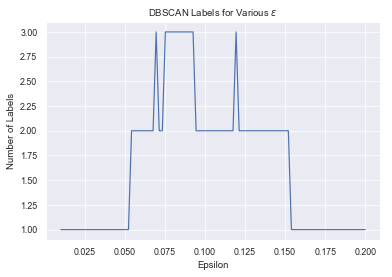

In [14]:
# epsilon values ranging from 0.01 to 0.2
epsilon_candidates = np.linspace(0.01, 0.2, 100)
n_labels = epsilon_candidates.copy()

for idx, ec in enumerate(epsilon_candidates):
    _dbscan = DBSCAN(metric='precomputed', eps=ec)
    _dbscan.fit(DISTANCES)
    
    n_labels[idx] = len(np.unique(_dbscan.labels_))

# plot results
plt.title('DBSCAN Labels for Various $\epsilon$');
plt.xlabel('Epsilon'); plt.ylabel('Number of Labels')
plt.plot(epsilon_candidates, n_labels);

This plot suggests that:

- DBSCAN has only one label for values in the ranges $[0.01, 0.05]$ and $[0.15, 0.2]$. These indicate values for $epsilon$ that are too small (every point is classified as noise) or too large (there is only one cluster)
- values in the range $[0.075, 0.08]$ consistently produce 2 labels (the third label is noise)
- spikes around values of $0.70$ and $0.12$ are likely not indicative of trends in the data, but are rather artifacts of DBSCAN

With these observations in mind, I decide to let $\epsilon = 0.08$. With this value, I fit the data to a DBSCAN model, and plot the results. 

In [15]:
# fit model
EPS = 0.08
avo_dbs = DBSCAN(metric='precomputed', eps=EPS)
avo_dbs.fit(DISTANCES)

# retrieve labels
labels = avo_dbs.labels_

> **Note**: The plot on top shows the time series for each region, colored by cluster, and outliers are the grey dotted lines. The plot on the bottom shows the "core" samples chosen by DBSCAN, which correspond to representative samples in that cluster; the bands show the minimum and maximum prices for that cluster at a given time period. 

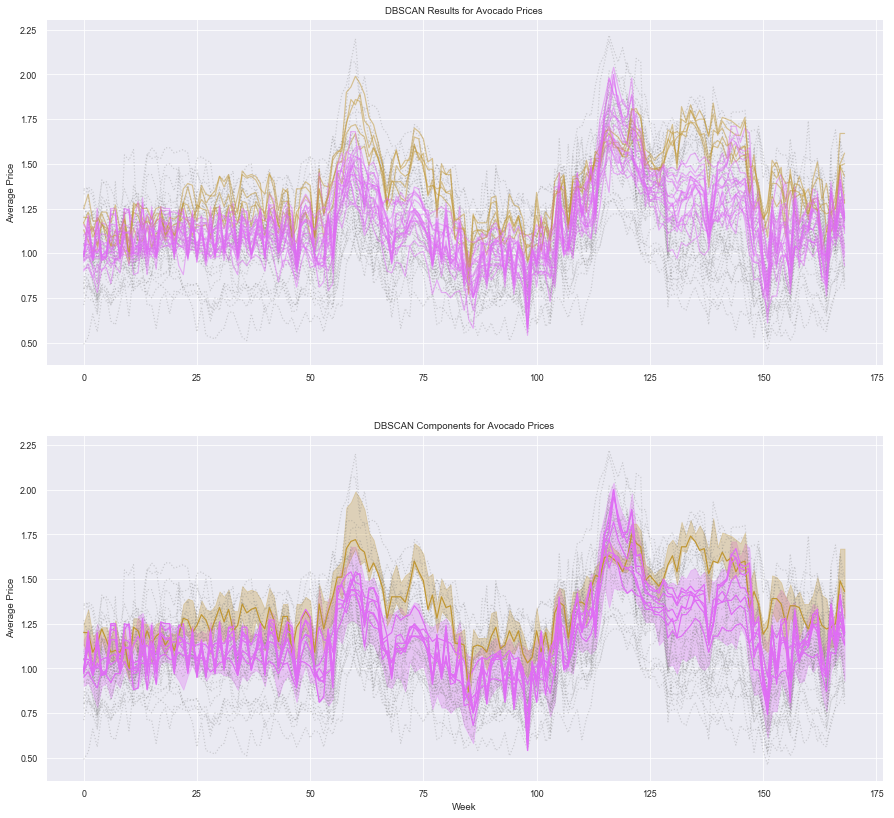

In [16]:
plot_dbscan_results(avo_dbs, avo)

The plot(s) above suggest that:

- one group represents high-priced avocados
- one group represents medium-priced avocados (with one short period of high-prices)

The outliers clearly don't fit in either, and seem to vary substantially. I would like to do more analysis on the outliers. I extract them and move onto the next step: using IsoForest to find anomalies in time.

## IsoForest

For a given region, I'd like to use IsoForest to detect anomalies in the trend in average price over time. This time series, however, only has one feature. To make up for this, I create a "sliding window" of time, like so:

$$W(u, 6) = 
\begin{bmatrix}
p_{u_1} & \cdots & p_{u_6} \\
p_{u_2} & \cdots & p_{u_7} \\
\vdots & & \vdots \\
p_{u_{T-5}} & \cdots & p_{u_T} 
\end{bmatrix}
$$

First, I choose a region that DBSCAN identified as an outlier, such as Sacramento. Then, construct the sliding window with a window size of 6.

In [17]:
avo_outliers = avo.loc[labels == -1]
sac = avo_outliers.loc['Sacramento']

In [18]:
def make_window_features(vector, window_size):
    n_windows = len(vector) - window_size - 1
    moving_window = np.zeros((n_windows, window_size))

    for w in range(n_windows):
        moving_window[w, :] = vector[w:w + window_size]
    return moving_window

In [19]:
WINDOW_SIZE = 6
sac_window = make_window_features(sac, WINDOW_SIZE)

Next, we train an IsoForest classifier, to identify the windows of the Sacramento data that are outliers. The plot below shows the results.

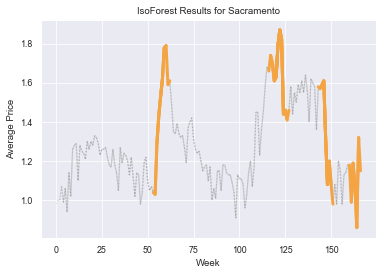

In [20]:
sac_iso = IsolationForest()
sac_iso.fit(sac_window)
sac_class = sac_iso.predict(sac_window)

plt.title('IsoForest Results for Sacramento')
plt.xlabel('Week'); plt.ylabel('Average Price');

for row in range(sac_window.shape[0]):
    _min = row
    _max = row + WINDOW_SIZE
    
    y = sac_window[row]
    x = range(row, row + WINDOW_SIZE)
    lab = sac_class[row]
    
    if lab == -1:
        plt.plot(x, y, color="#f4a442", zorder=2, lw=3);
    else:
        plt.plot(x, y, color='grey', zorder=1, alpha=0.2, ls=":");

The plot suggests that several windows were identified out outliers, and they seem to correspond to three unique periods: a large increase then decrease in price, a period of fluctuating, yet high prices, and a steep drop in prices. This suggests that IsoForest is able to identify "outliers" for time series using the sliding-window technique. 

I now show the results for _all_ of the outlier regions. The plot below only shows the anomalous time windows.

In [21]:
# store IsoForest data in a dictionary
iso_data = dict()

for region in avo_outliers.index:
    # transform region price data (a vector) into a 
    # sliding-window array
    _region_data = avo_outliers.loc[region]
    _window = make_window_features(_region_data, WINDOW_SIZE)
    
    # fit an IsoForest to the data, and get labels
    _iso = IsolationForest()
    _iso.fit(_window)
    _labels = _iso.predict(_window)
    
    # store data: { region: (window, labels)}
    iso_data[region] = (_window, _labels)

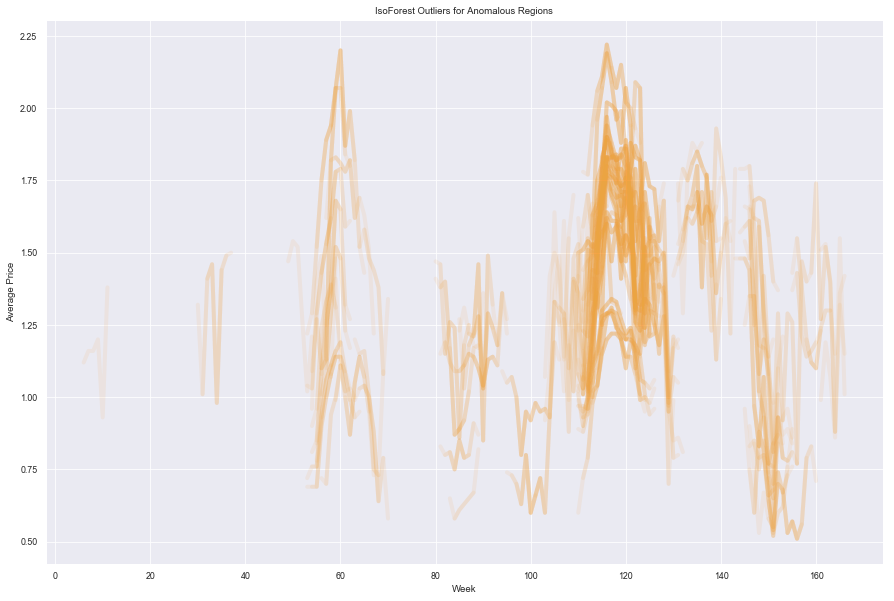

In [22]:
fig = plt.figure(figsize=(15, 10))

plt.title('IsoForest Outliers for Anomalous Regions')
plt.xlabel('Week'); plt.ylabel('Average Price')

# plot windows for each region
for region, (window, labs) in iso_data.items():    
    # each row represents a window of time
    # only plot the windows that are outliers
    # in their respective datasets, in order to 
    # reduce visual clutter
    for row in range(window.shape[0]):
        if labs[row] == -1:
            # ensures that segments are plotted in the
            # proper time slot
            _x = range(row, row + WINDOW_SIZE)
            _y = window[row]
            
            # plot transparent orange lines, which will give a 
            # sense of density to the plot, indicating clusters
            plt.plot(_x, _y, color="#f4a442", alpha=0.1, lw=4, ls='-')
        

The plot suggests observations similar to the ones seen in the Sacramento data:

- a large spike in prices around week 60
- another large increase in prices around week 120
- high variability in prices between weeks 140 and 160

In summary, DBSCAN was used to detect regions that were not similar to the others. I considered these regions to be anomalous, and therefore worth more investigation. I then selected these regions, and used IsoForest to detect time periods that deviated from the overall trend (for each region). This information could be used to do further research about the regions or time periods of interest, to better understand the changes in avocado prices.

# Conclusions

While no general-purpose approach to outlier detection exists, there are a number of strategies and methods one can use to identify outliers in their data. For example, in the GPS data, DBCSAN and IsoForest identified outliers with varying degrees of accuracy. These methods can be applied to similar problems, so that your GPS trajectories will be free of outliers when you need them.

Furthermore, outlier detection can be more open-ended. In cases where outliers are naturally occurring, one would like to detect them for further research. In the case of the Avocado prices, I used DBSCAN to find anomalous regions, and used IsoForest to find anomalous time periods within those regions. Thus, outlier detection can be incorporated into more sophisticated pipelines.

Overall, outlier detection is domain-specific, or even dataset-specific. Outliers can vary in nature in severity, from a measurement error that can be ignored, to a maliciously placed data point that needs to be resolved. The methods outlined above provide an introduction to their uses and versatility.

# References

1. Hawkins D.M. (1980) Introduction. In: Identification of Outliers. Monographs on Applied Probability and Statistics. Springer, Dordrecht

2. Jinka, Schwartz (2016) Anomaly Detection for Monitoring. O'Reilly Media, Inc.

3. [Ester, Martin, et al. "A density-based algorithm for discovering clusters in large spatial databases with noise." Kdd. Vol. 96. No. 34. 1996.](http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

4. [scikit-learn DBSCAN documentation](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

5. [scikit-learn DBSCAN User Guide](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

6. [Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. "Isolation forest." 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)

7. [scikit-learn IsolationForest documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

8. [scikit-learn IsolationForest User Guide](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest)
